In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import read_raw_network_data

## Reading data ##

In [2]:
trafo_id = "T0932" #T1330 T0932
data, _ = read_raw_network_data(trafo_id, depth=1)

In [3]:
data.keys()

dict_keys(['lines_static_data', 'nodes_static_data', 'SMM_measurements', 'TP_measurements'])

In [4]:
data_nodes = data["nodes_static_data"]
data_edges = data["lines_static_data"]
data_ts_smm = data["SMM_measurements"]
data_ts_tp = data["TP_measurements"]

In [5]:
data_ts_tp.head()

,trafo_id,trafo_station_id,date_time,active_power,reactive_power,voltage,current
0,1238,728,2021-06-01 05:10:00,44330,5590,229.316667,65.583333
1,1238,728,2021-06-01 04:10:00,38430,2240,230.873333,56.783333
2,1238,728,2021-06-01 00:40:00,47230,2730,232.293333,69.066667
3,1238,728,2021-06-01 02:20:00,37710,2760,231.056667,55.683333
4,1238,728,2021-06-01 05:55:00,49020,4490,229.550000,72.183333


## Preprocessing ##

### Node preprocessing ###

In [6]:
def aggr_by_bus_aclassid(data_nodes_proc):
    """
    Aggregates nodes by bus and aclass_id and returns a dataframe with the aggregated data.
    """

    #copy of code from 02-kk-create-nx.ipynb
    data_nodes_aggr = data_nodes_proc.groupby(["bus", "aclass_id"]).agg(list)
    data_nodes_aggr = data_nodes_aggr.rename(columns={"smm": "smm_list"})
    data_nodes_aggr["x_y"] = data_nodes_aggr["x_y"].apply(lambda x: x[0])
    data_nodes_aggr["lon_lat"] = data_nodes_aggr["lon_lat"].apply(lambda x: x[0])
    data_nodes_aggr = data_nodes_aggr.reset_index()
    
    #dictionaries for mapping from bus and smm_list to nodeid
    dict_of_bus_to_nodeid = dict(zip(data_nodes_aggr["bus"].tolist(), range(len(data_nodes_aggr))))
    dict_of_smms_to_nodeid =  { x: i for i, y in enumerate(data_nodes_aggr["smm_list"].tolist()) if (y!= None) for x in y }
    
    #map bus to node_id
    data_nodes_aggr.insert(0, "node_id", range(len(data_nodes_aggr)))
    data_nodes_aggr["node_id"] = data_nodes_aggr["bus"].apply(lambda x: dict_of_bus_to_nodeid[x])
    
    #aggregate prikljucna_moc_odjem to prikljucna_moc_odjem_aggr
    data_nodes_aggr.insert(5, "prikljucna_moc_odjem_aggr", data_nodes_aggr["prikljucna_moc_odjem"].apply(sum))
    
    #aggregate prikljucna_moc_oddaja to prikljucna_moc_oddaja_aggr
    data_nodes_aggr.insert(7, "prikljucna_moc_oddaja_aggr", data_nodes_aggr["prikljucna_moc_oddaja"].apply(sum))
    
    data_nodes_aggr = data_nodes_aggr.drop(columns=["bus"])
    
    return data_nodes_aggr, dict_of_bus_to_nodeid, dict_of_smms_to_nodeid

In [7]:
# data_test[[dict_smms2nodeid[tuple(x)] for x in data_test["smm_list"]] != data_test["node_id"]]

In [8]:
def preprocess_nodes(data_nodes_proc):
    """
    Preprocesses nodes data and returns a dataframe with the aggregated data and dictionaries for mapping from bus and smm_list to nodeid.
    """
    
    data_nodes_proc, dict_bus2nodeid, dict_smms2nodeid = aggr_by_bus_aclassid(data_nodes_proc)
    
    return data_nodes_proc, dict_bus2nodeid, dict_smms2nodeid

### Edge preprocessing ###

In [9]:
def preprocess_edges(data_edges_proc, dict_bus2nodeid):
    
    data_edges_proc.insert(0, "from_node_id", range(len(data_edges_proc)))
    data_edges_proc["from_node_id"] = data_edges_proc["from_bus"].apply(lambda x: dict_bus2nodeid[x])
    data_edges_proc = data_edges_proc.drop(columns=["from_bus"])
    
    data_edges_proc.insert(1, "to_node_id", range(len(data_edges_proc)))
    data_edges_proc["to_node_id"] = data_edges_proc["to_bus"].apply(lambda x: dict_bus2nodeid[x])
    data_edges_proc = data_edges_proc.drop(columns=["to_bus"])
    
    return data_edges_proc

### Preprocessing tp timeseries ###

In [10]:
def preprocess_ts_tp(data_ts_tp_proc, dict_bus2nodeid):
    
    data_ts_tp_proc.insert(0, "trafo_node_id", np.zeros(len(data_ts_tp_proc)))
    data_ts_tp_proc.drop(columns=["trafo_id", "trafo_station_id"], inplace=True)
    
    return data_ts_tp_proc

### Preprocessing smm timeseries ###

In [11]:
def map_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid):
    
    # print(type(data_ts_smm_proc["SMM"]))
    
    data_ts_smm_proc.insert(0, "node_id", range(len(data_ts_smm_proc)))

    data_ts_smm_proc["node_id"] = data_ts_smm_proc["SMM"].apply(lambda x: dict_smms2nodeid[x])
    data_ts_smm_proc = data_ts_smm_proc.drop(columns=["SMM"])
    
    # data_ts_smm_proc.insert(0, "trafo_station_node_id", range(len(data_ts_smm_proc)))
    # data_ts_smm_proc["trafo_station_node_id"] = data_ts_smm_proc["trafo_station_id"].map(lambda x: dict_bus2nodeid[x])
    
    return data_ts_smm_proc

In [12]:
def preprocess_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid):
    
    data_ts_smm_proc = map_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid)
    
    data_ts_smm_proc.insert(1, "trafo_node_id", np.zeros(len(data_ts_smm_proc)))
    data_ts_smm_proc.drop(columns=["trafo_id", "trafo_station_id"], inplace=True)
    
    return data_ts_smm_proc

### Puting preprocessing together ###

In [13]:
def preprocess(data_preprocess):
    """
    Preprocesses the data.
    """
    data_preprocessed = data_preprocess.copy()
    data_nodes_proc = data_preprocessed["nodes_static_data"]
    data_edges_proc = data_preprocessed["lines_static_data"]
    data_ts_smm_proc = data_preprocessed["SMM_measurements"]
    data_ts_tp_proc = data_preprocessed["TP_measurements"]
    
    data_nodes_proc, dict_bus2nodeid, dict_smms2nodeid = preprocess_nodes(data_nodes_proc)
    trafo_node_id = 0
    data_edges_proc = preprocess_edges(data_edges_proc, dict_bus2nodeid)
    data_ts_smm_proc = preprocess_ts_smm(data_ts_smm_proc, dict_smms2nodeid, dict_bus2nodeid)
    data_ts_tp_proc = preprocess_ts_tp(data_ts_tp_proc, dict_bus2nodeid)
    
    data_preprocessed["nodes_static_data"] = data_nodes_proc
    data_preprocessed["lines_static_data"] = data_edges_proc
    data_preprocessed["SMM_measurements"] = data_ts_smm_proc
    data_preprocessed["TP_measurements"] = data_ts_tp_proc
    
    return data_preprocessed, dict_bus2nodeid, dict_smms2nodeid
    

## Testing ##

In [17]:
#run every time you want to preprocess the data
data_test = data.copy()
data_test["nodes_static_data"] = data_nodes.copy(deep=True)
data_test["lines_static_data"] = data_edges.copy(deep=True)
data_test["SMM_measurements"] = data_ts_smm.copy(deep=True)
data_test["TP_measurements"] = data_ts_tp.copy(deep=True)

In [18]:
#This can be run only once, because the data_test is partially modified in the process
data_test, dict_bus2nodeid_test, dict_smms2nodeid_test = preprocess(data_test)

In [19]:
data_test["nodes_static_data"].head()

,node_id,aclass_id,smm_list,prikljucna_moc_odjem,prikljucna_moc_odjem_aggr,prikljucna_moc_oddaja,prikljucna_moc_oddaja_aggr,x_y,lon_lat
0,0,TR,[nan],[nan],NaN,[nan],NaN,"(520382.7308, 152363.97890000045)","(21.35663109152071, 49.23921049220127)"
1,1,RO,[nan],[nan],NaN,[nan],NaN,"(520358.67059999984, 152374.78979999945)","(21.35631799434757, 49.239305998608415)"
2,2,RO,[nan],[nan],NaN,[nan],NaN,"(520358.5504999999, 152373.9098000005)","(21.356316529734652, 49.239298072747516)"
3,3,RO,[nan],[nan],NaN,[nan],NaN,"(520370.45210000034, 152414.26999999955)","(21.3564665985539, 49.23966204996808)"
4,4,RO,[nan],[nan],NaN,[nan],NaN,"(520369.32210000046, 152414.36999999918)","(21.356451936558535, 49.23966286716428)"


In [20]:
data_test["lines_static_data"][20:25]

,from_node_id,to_node_id,length_km,r_ohm_per_km,x_ohm_per_km,max_i_ka,type,d_mm2,coords,coords_transformed
20,42,57,0.011,0.771000,0.081000,0.143,cs,50.0,"[[520363.5044, 152491.20130000077], [520363.34...","[[21.35636842206784, 49.24035367038454], [21.3..."
21,31,32,0.010,2.233400,0.094200,0.079,cs,10.0,"[[520368.9018000001, 152404.38990000077], [520...","[[21.35644753676697, 49.239573048553844], [21...."
22,34,57,0.010,0.533000,0.079000,0.176,cs,70.0,"[[520363.3446000004, 152496.4313999992], [5203...","[[21.35636579986574, 49.24040071233683], [21.3..."
23,28,36,0.014,3.707214,0.059643,0.059,cs,6.0,"[[520369.6843999997, 152485.52109999955], [520...","[[21.35644914988739, 49.24030301844388], [21.3..."
24,36,37,0.006,2.233333,0.094167,0.079,cs,10.0,"[[520368.1442999998, 152482.7111000009], [5203...","[[21.356429476450533, 49.24027762531932], [21...."


In [21]:
data_test["TP_measurements"].head()

,trafo_node_id,date_time,active_power,reactive_power,voltage,current
0,0.0,2021-06-01 05:10:00,44330,5590,229.316667,65.583333
1,0.0,2021-06-01 04:10:00,38430,2240,230.873333,56.783333
2,0.0,2021-06-01 00:40:00,47230,2730,232.293333,69.066667
3,0.0,2021-06-01 02:20:00,37710,2760,231.056667,55.683333
4,0.0,2021-06-01 05:55:00,49020,4490,229.550000,72.183333


In [22]:
data_test["SMM_measurements"].head()

,node_id,trafo_node_id,active_energy,active_power,reactive_energy,reactive_power,date_time,current,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance
0,12,0.0,0.000,0.000,0.0,0.0,2021-06-01 14:15:00,NaN,231.933333,19.223501,0.0,20.400002,1.0,558.25,338.00,220.25,452.74506
1,12,0.0,0.000,0.000,0.0,0.0,2021-06-01 06:15:00,NaN,231.600000,13.986000,0.0,15.150000,1.0,296.25,200.25,96.00,513.05870
2,12,0.0,0.000,0.000,0.0,0.0,2021-06-01 06:00:00,NaN,230.500000,13.661000,0.0,15.900000,1.0,273.00,188.00,85.00,530.83200
3,7,0.0,0.002,0.008,0.0,0.0,2021-06-01 01:45:00,NaN,232.133333,12.506000,0.0,9.525001,0.0,0.00,0.00,0.00,0.00000
4,56,0.0,0.009,0.036,0.0,0.0,2021-06-01 01:45:00,NaN,232.200000,12.473500,0.0,9.525001,0.0,0.00,0.00,0.00,0.00000


### Visualization ###
copy from 02-kk-reate-nx

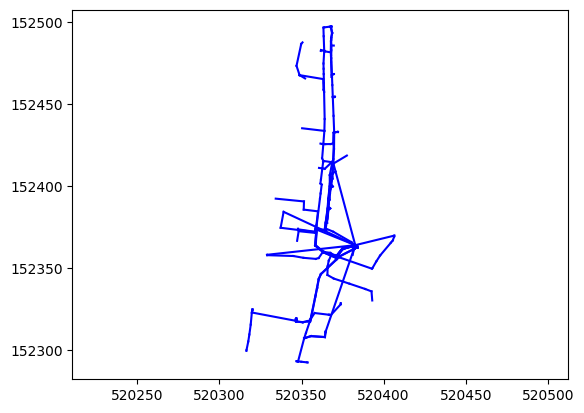

In [23]:
import matplotlib.pyplot as plt

for row in data_test["lines_static_data"].iterrows():
    coords = row[1]["coords"]
    #transform string to list of tuples
    coords = eval(coords)
    for i in range(len(coords)-1):
        x0, y0 = coords[i]
        x1, y1 = coords[i+1]
        plt.plot([x0, x1], [y0, y1], "b")
#show plot with equal axis dimensions
plt.axis("equal")
plt.show()

In [24]:
data_nodes_dict = data_test["nodes_static_data"].set_index("node_id").to_dict(orient="index")
data_nodes_dict

{0: {'aclass_id': 'TR',
  'smm_list': [nan],
  'prikljucna_moc_odjem': [nan],
  'prikljucna_moc_odjem_aggr': nan,
  'prikljucna_moc_oddaja': [nan],
  'prikljucna_moc_oddaja_aggr': nan,
  'x_y': '(520382.7308, 152363.97890000045)',
  'lon_lat': '(21.35663109152071, 49.23921049220127)'},
 1: {'aclass_id': 'RO',
  'smm_list': [nan],
  'prikljucna_moc_odjem': [nan],
  'prikljucna_moc_odjem_aggr': nan,
  'prikljucna_moc_oddaja': [nan],
  'prikljucna_moc_oddaja_aggr': nan,
  'x_y': '(520358.67059999984, 152374.78979999945)',
  'lon_lat': '(21.35631799434757, 49.239305998608415)'},
 2: {'aclass_id': 'RO',
  'smm_list': [nan],
  'prikljucna_moc_odjem': [nan],
  'prikljucna_moc_odjem_aggr': nan,
  'prikljucna_moc_oddaja': [nan],
  'prikljucna_moc_oddaja_aggr': nan,
  'x_y': '(520358.5504999999, 152373.9098000005)',
  'lon_lat': '(21.356316529734652, 49.239298072747516)'},
 3: {'aclass_id': 'RO',
  'smm_list': [nan],
  'prikljucna_moc_odjem': [nan],
  'prikljucna_moc_odjem_aggr': nan,
  'priklju

In [25]:
import networkx as nx

#create undirected networkx graph from data_nodes and data_edges
G = nx.from_pandas_edgelist(data_test["lines_static_data"], source="from_node_id", target="to_node_id", edge_attr=True)
#set node attributes from data_nodes_aggr_dict
nx.set_node_attributes(G, data_nodes_dict)


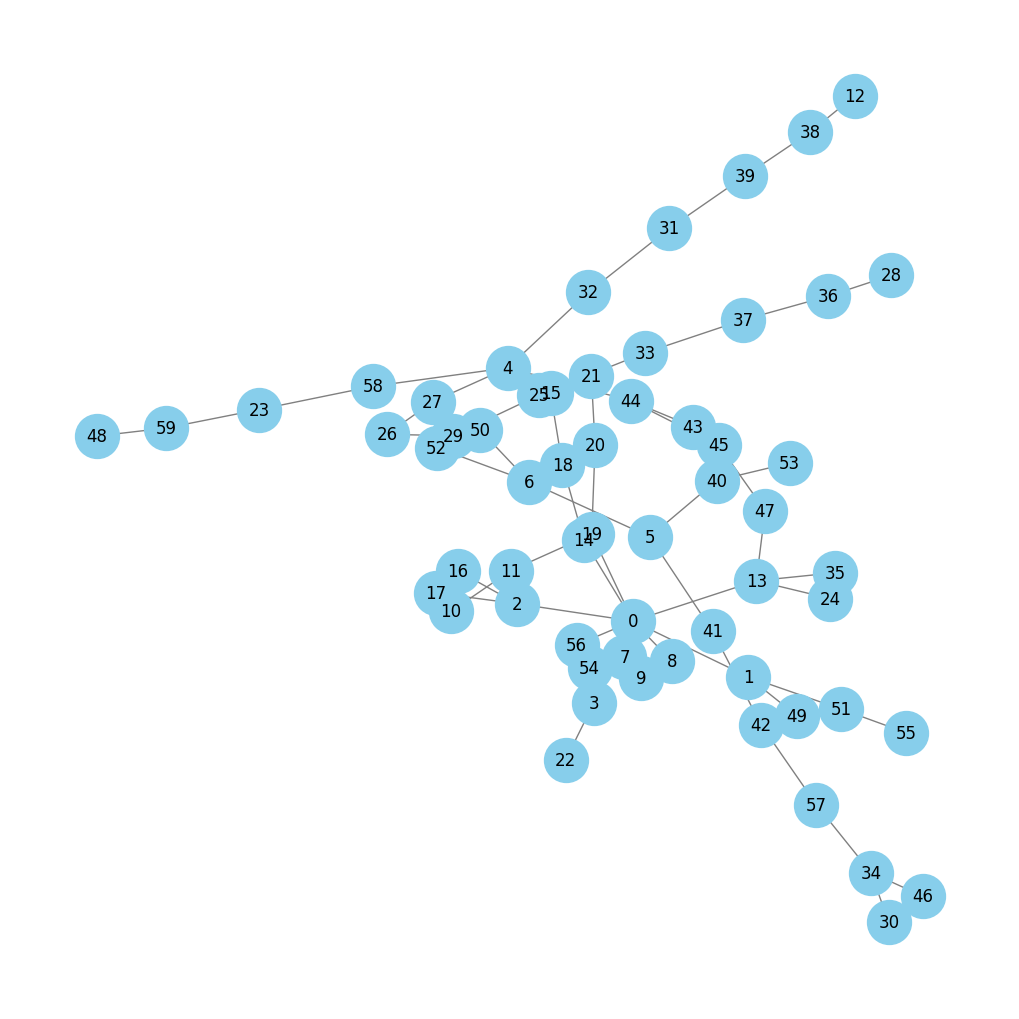

In [26]:
#plot the network

plt.figure(figsize=(10,10))
nx.draw(G, with_labels=True, node_size=1000, node_color="skyblue", edge_color="grey")
plt.show()
